In [22]:
import pandas as pd
import numpy as np

In [23]:
pip install category_encoders

In [42]:
crime = pd.read_csv("crime_weather_preprocessed")
print(crime.columns)
print(crime.shape[0])

Index(['ucr_desc', 'offense_date', 'census_block', 'lat', 'lon',
       'offense_year', 'temp_max', 'temp_min', 'daylight_duration',
       'precipitation_sum', 'precipitation_hours', 'dow_sin', 'dow_cos',
       'day_sin', 'day_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'ucr_desc_numeric', 'offense_year_numeric', 'census_block_numeric',
       'week_of_year', 'week_precipitation_interaction',
       'daylight_precipitation_interaction', 'block_week_interaction',
       'block_temp_max_interaction', 'temp_range',
       'temp_range_precipitation_interaction',
       'precipitation_sum_hours_interaction', 'is_holiday'],
      dtype='object')
498581


In [43]:
# Feature Engineering Functions (from Step 1)
def add_weekly_lag_features(df, target_column, lags):
    df = df.sort_values(['census_block_numeric', 'date'])
    for lag in lags:
        lag_column_name = f"{target_column}_lag{lag}w"
        df[lag_column_name] = df.groupby('census_block_numeric')[target_column].shift(lag)
    return df

def add_rolling_features(df, target_column, windows):
    df = df.sort_values(['census_block_numeric', 'date'])
    for window in windows:
        rolling_column_name = f"{target_column}_rolling{window}"
        df[rolling_column_name] = df.groupby('census_block_numeric')[target_column].transform(
            lambda x: x.shift(1).rolling(window=window).mean()
        )
    return df

In [44]:
def create_time_series(data):
    # Ensure 'offense_date' is datetime
    data['offense_date'] = pd.to_datetime(data['offense_date'], errors='coerce')

    # Set 'offense_date' as index for grouping
    data.set_index('offense_date', inplace=True)

    # Sort the data
    data = data.sort_values(by=['census_block_numeric', 'offense_date'])

    # Define the aggregation functions for each feature
    agg_dict = {
        'dow_sin': 'mean',
        'dow_cos': 'mean',
        'day_sin': 'mean',
        'day_cos': 'mean',
        'month_sin': 'mean',
        'month_cos': 'mean',
        'temp_max': 'mean',
        'temp_min': 'mean',
        'daylight_duration': 'mean',
        'precipitation_sum': 'mean',
        'precipitation_hours': 'mean',
        'week_precipitation_interaction': 'mean',
        'daylight_precipitation_interaction': 'mean',
        'block_week_interaction': 'mean',
        'block_temp_max_interaction': 'mean',
        'temp_range': 'mean',
        'temp_range_precipitation_interaction': 'mean',
        'is_holiday': 'mean',
        'week_of_year': 'first'
    }

    # Group by 'census_block_numeric' and weekly intervals
    time_series = data.groupby(['census_block_numeric', pd.Grouper(freq='W')]).agg(agg_dict).reset_index()

    # Calculate the weekly crime count per census block
    time_series['Crime_Count_W'] = data.groupby(['census_block_numeric', pd.Grouper(freq='W')]).size().values

    # Rename 'offense_date' back to 'date' if needed
    time_series.rename(columns={'offense_date': 'date'}, inplace=True)

    # Sort the time series
    time_series = time_series.sort_values(by=['census_block_numeric', 'date'])

    # Add lag features
    lag_intervals = [1, 4, 12, 24, 52]
    time_series = add_weekly_lag_features(time_series, target_column='Crime_Count_W', lags=lag_intervals)

    # Add rolling features
    rolling_windows = [2, 3, 4, 8, 15]
    time_series = add_rolling_features(time_series, target_column='Crime_Count_W', windows=rolling_windows)

    # Create interaction features
    for window in rolling_windows:
        time_series[f'week_rolling{window}_interaction'] = (
            time_series['week_of_year'] * time_series[f'Crime_Count_W_rolling{window}']
        )
        time_series[f'temp_rolling{window}_interaction'] = (
            time_series['temp_range'] * time_series[f'Crime_Count_W_rolling{window}']
        )
        time_series[f'precip_rolling{window}_interaction'] = (
            time_series['precipitation_hours'] * time_series[f'Crime_Count_W_rolling{window}']
        )

    for lag in lag_intervals:
        time_series[f'daylight_lag{lag}_interaction'] = (
            time_series['daylight_duration'] * time_series[f'Crime_Count_W_lag{lag}w']
        )
        
    time_series = time_series.dropna()
    
    # Define features to apply log transformation
    log_features = [
        'Crime_Count_W', 
        'Crime_Count_W_lag1w', 'Crime_Count_W_lag4w',
        'Crime_Count_W_lag12w', 'Crime_Count_W_lag24w', 'Crime_Count_W_lag52w',
        'Crime_Count_W_rolling2', 'Crime_Count_W_rolling3', 'Crime_Count_W_rolling4',
        'Crime_Count_W_rolling8', 'Crime_Count_W_rolling15',
        'week_rolling2_interaction', 'temp_rolling2_interaction',
        'precip_rolling2_interaction', 'week_rolling3_interaction',
        'temp_rolling3_interaction', 'precip_rolling3_interaction',
        'week_rolling4_interaction', 'temp_rolling4_interaction',
        'precip_rolling4_interaction', 'week_rolling8_interaction',
        'temp_rolling8_interaction', 'precip_rolling8_interaction',
        'week_rolling15_interaction', 'temp_rolling15_interaction',
        'precip_rolling15_interaction', 'daylight_lag1_interaction',
        'daylight_lag4_interaction', 'daylight_lag12_interaction',
        'daylight_lag24_interaction', 'daylight_lag52_interaction'
    ]
    
    # Apply log1p transformation to specified features
    time_series[log_features] = time_series[log_features].apply(lambda x: np.log1p(x))
    
    # Reset index if needed
    time_series.reset_index(drop=True, inplace=True)

    return time_series

In [45]:
crime_time_series = create_time_series(crime)
crime_time_series

,census_block_numeric,date,dow_sin,dow_cos,day_sin,day_cos,month_sin,month_cos,temp_max,temp_min,...,temp_rolling8_interaction,precip_rolling8_interaction,week_rolling15_interaction,temp_rolling15_interaction,precip_rolling15_interaction,daylight_lag1_interaction,daylight_lag4_interaction,daylight_lag12_interaction,daylight_lag24_interaction,daylight_lag52_interaction
0,0,2019-01-06,0.251096,-0.087745,0.222764,0.912469,-0.084615,0.977327,50.575003,31.292849,...,6.923356,5.644550,4.004906,6.946654,5.667789,14.151481,14.491348,14.220474,14.439163,14.540945
1,0,2019-01-13,0.072602,-0.027041,0.914477,-0.134381,0.000000,1.000000,39.343676,27.010076,...,6.493523,6.090948,4.688898,6.500343,6.097763,14.602044,14.632350,14.378901,14.234320,14.211847
2,0,2019-01-20,-0.105186,-0.019377,-0.148020,-0.913020,0.000000,1.000000,30.640884,21.123962,...,6.230041,6.317130,5.077671,6.227852,6.314941,14.359764,14.590876,14.473093,14.508184,14.003089
3,0,2019-01-27,-0.119187,-0.081683,-0.930880,-0.005172,0.000000,1.000000,31.862450,14.243449,...,6.847383,5.906746,5.348694,6.827695,5.887091,14.133096,14.207204,14.512585,14.800267,14.494886
4,0,2019-02-03,-0.069638,0.291656,-0.164648,0.874049,0.250000,0.933013,38.122796,12.193154,...,7.274713,5.271430,5.589742,7.232671,5.229580,14.588748,14.668790,14.554846,14.537455,14.207975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34896,242,2023-12-31,0.433884,-0.900969,-0.848644,0.528964,-0.500000,0.866025,51.206001,44.456001,...,2.244691,3.102342,4.473542,2.505526,3.378725,10.407002,11.100134,11.100134,11.100134,11.100134
34897,242,2024-01-07,0.781831,0.623490,0.000000,1.000000,0.000000,1.000000,35.186001,30.776001,...,1.873723,2.983153,0.955511,2.086417,3.218876,10.412166,10.412166,11.510758,10.412166,10.412166
34898,242,2024-03-03,0.000000,1.000000,0.394356,0.918958,0.866025,0.500000,60.116001,37.166000,...,3.390726,0.000000,2.734368,3.630190,0.000000,10.620991,11.314126,12.007268,11.314126,11.719587
34899,242,2024-05-19,0.781831,0.623490,0.651372,-0.758758,0.866025,-0.500000,77.216003,53.096001,...,3.615771,0.000000,3.574217,3.756725,0.000000,11.959410,10.860810,11.553948,10.860810,10.860810


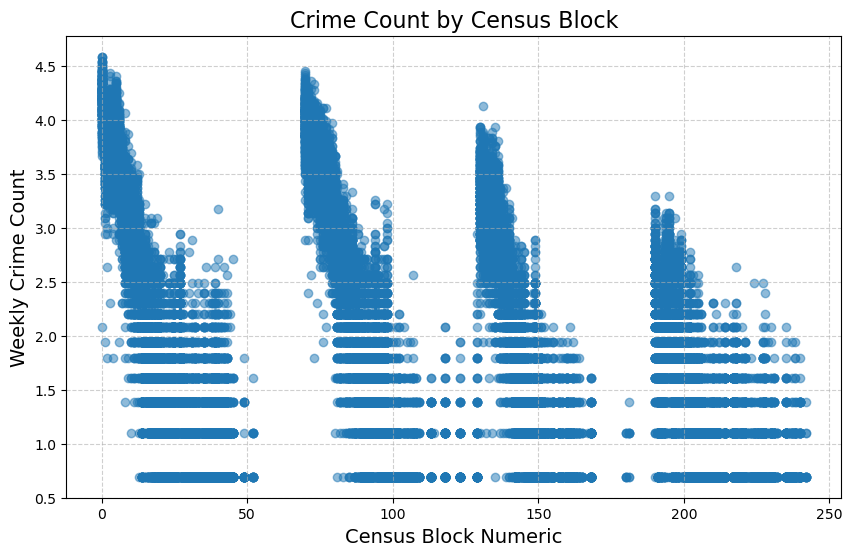

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(crime_time_series['census_block_numeric'], crime_time_series['Crime_Count_W'], alpha=0.5)
plt.title('Crime Count by Census Block', fontsize=16)
plt.xlabel('Census Block Numeric', fontsize=14)
plt.ylabel('Weekly Crime Count', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

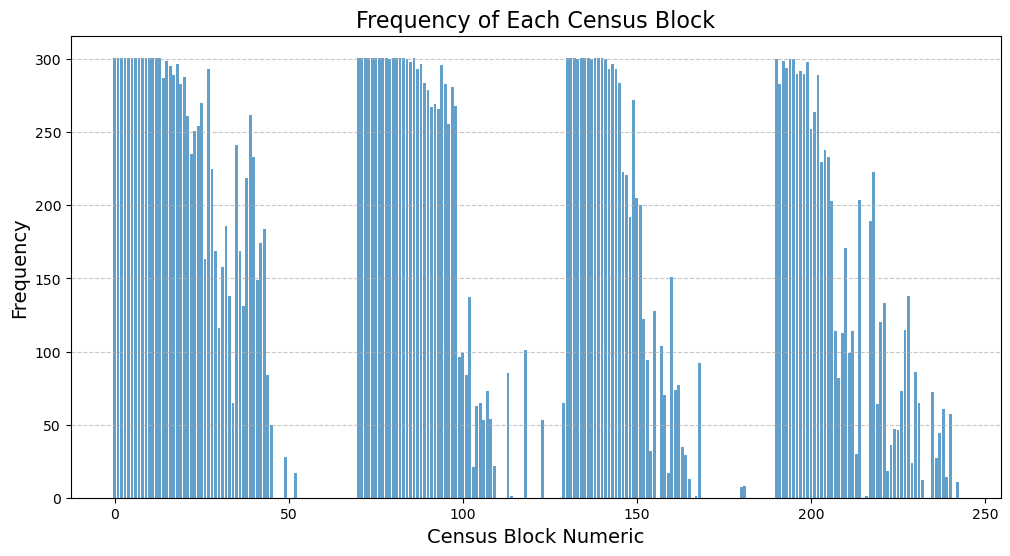

In [21]:
# Create a frequency table for 'census_block_numeric'
frequency = crime_time_series['census_block_numeric'].value_counts()

# Plot the frequency distribution
plt.figure(figsize=(12, 6))
plt.bar(frequency.index, frequency.values, alpha=0.7)
plt.title('Frequency of Each Census Block', fontsize=16)
plt.xlabel('Census Block Numeric', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

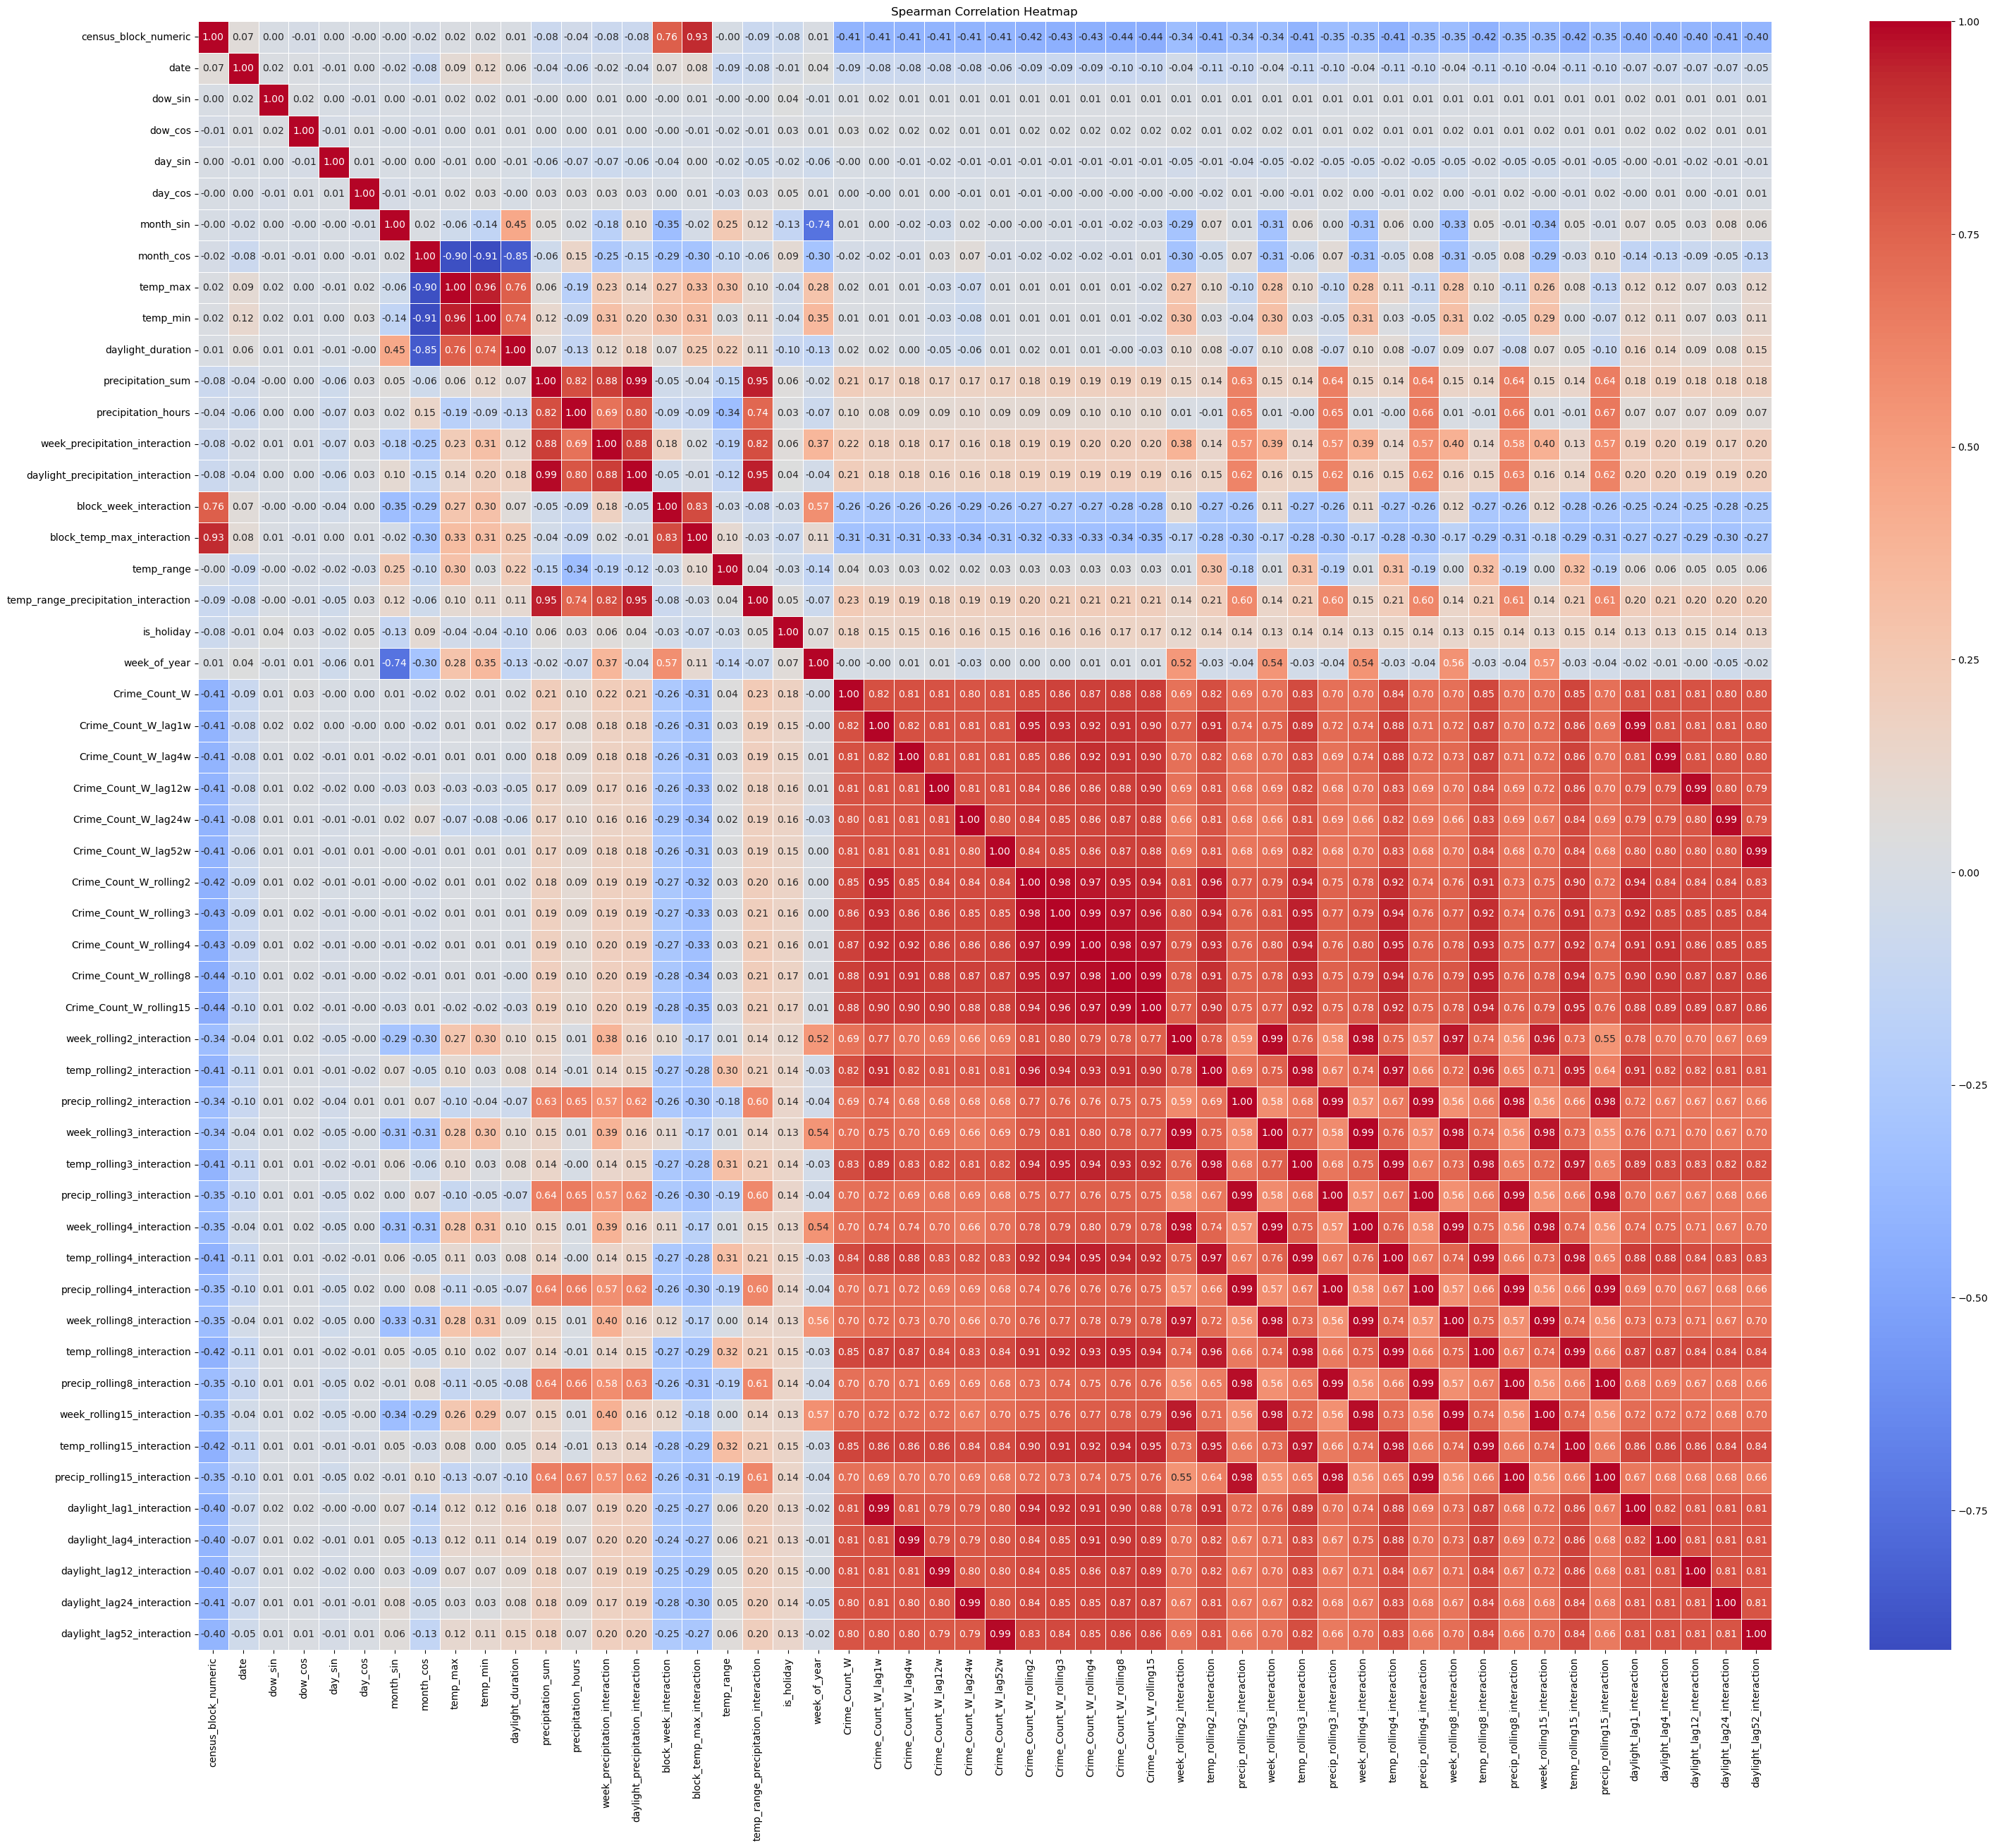

In [114]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the Spearman correlation matrix
spearman_corr = crime_time_series.corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(36, 30))
sns.heatmap(
    spearman_corr, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    cbar=True, 
    linewidths=0.5
)
plt.title('Spearman Correlation Heatmap')
plt.show()

                                 Feature  MI_Score
2                                dow_cos  1.541056
1                                dow_sin  1.257694
11                   precipitation_hours  1.099954
0                   census_block_numeric  0.880169
29               Crime_Count_W_rolling15  0.865774
28                Crime_Count_W_rolling8  0.857507
27                Crime_Count_W_rolling4  0.822614
4                                day_cos  0.808404
26                Crime_Count_W_rolling3  0.802733
25                Crime_Count_W_rolling2  0.759794
40             temp_rolling8_interaction  0.753739
43            temp_rolling15_interaction  0.744562
37             temp_rolling4_interaction  0.734289
34             temp_rolling3_interaction  0.731876
31             temp_rolling2_interaction  0.704811
32           precip_rolling2_interaction  0.675820
20                   Crime_Count_W_lag1w  0.670065
21                   Crime_Count_W_lag4w  0.660411
3                              

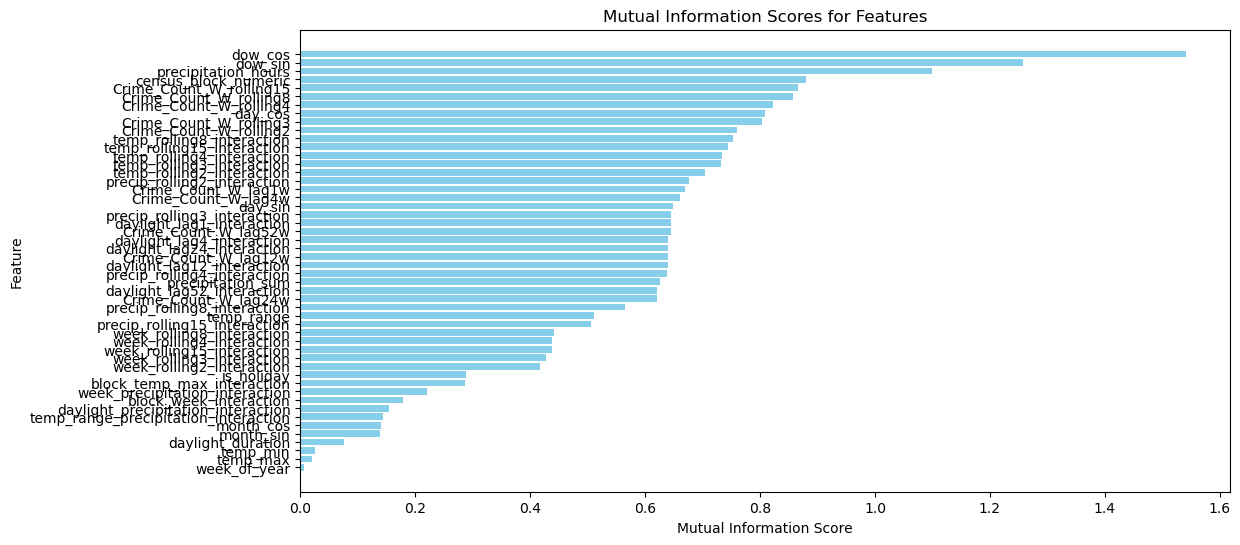

In [66]:
from sklearn.feature_selection import mutual_info_regression

# Separate features and target
X = crime_time_series.drop(columns=['Crime_Count_W', 'date'])  # Features
y = crime_time_series['Crime_Count_W']  # Target variable

# Compute Mutual Information (MI) scores
mi_scores = mutual_info_regression(X, y, random_state=42)

# Create a DataFrame to store feature names and their corresponding MI scores
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values(by='MI_Score', ascending=False)

# Display MI scores
print(mi_df)

# Optional: Plot MI Scores
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(mi_df['Feature'], mi_df['MI_Score'], color='skyblue')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Mutual Information Scores for Features')
plt.gca().invert_yaxis()  # Reverse order for better visualization
plt.show()

In [46]:
# Important to note that we do not perform any feature scaling here
# This is because random forests are scale-invariant

crime_time_series.to_csv("crime_weather_weekly_time_series", index=False)